/tmp/ipykernel_26075/1477753836.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x)


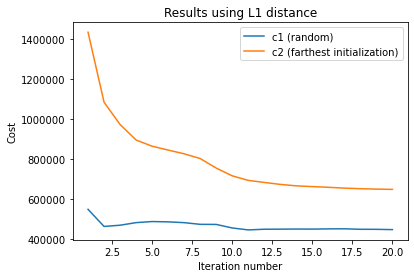

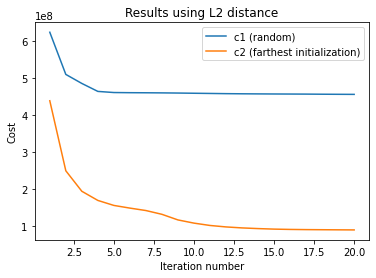

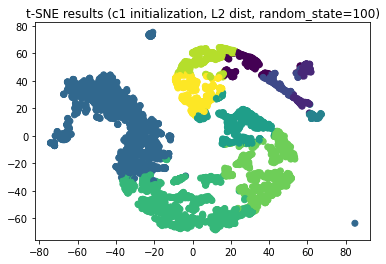

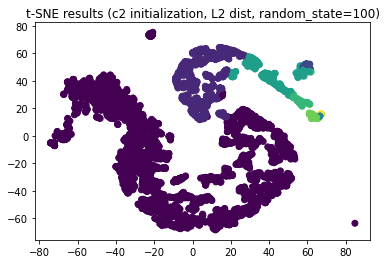

In [4]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Macros.
MAX_ITER = 20
# DATA_PATH = "your data.txt cloud storage URI"
# C1_PATH = "your c1.txt cloud storage URI"
# C2_PATH = "your c2.txt cloud storage URI"
DATA_PATH = "gs://mk4427input/data.txt"
C1_PATH = "gs://mk4427input/c1.txt"
C2_PATH = "gs://mk4427input/c2.txt"
NORM = 1


# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c


# K-means clustering
def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # iterative k-means
    loss = []
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))

        data_transform = data.map(lambda p:(closest(p, centroids,norm),(p,1)))

        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count

        data_dist = data_transform.map(
            lambda p:linalg.norm(p[1][0] - centroids[p[0]], norm) ** norm)
        loss.append(sum(data_dist.collect()))

        # Average the points for each centroid: divide sum of points by count

        clusters = data_transform.reduceByKey(
            lambda p1_c, p2_c: (p1_c[0]+p2_c[0], p1_c[1]+p2_c[1]))

        # Use collect() to turn RDD into list

        centroids = clusters.map(
            lambda c:c[1][0]/c[1][1]).collect()

        #pass
    return data_transform, centroids, loss


def main():
    # Spark settings
    conf = SparkConf()
    #sc = SparkContext(conf=conf).getOrCreate()
    sc = SparkContext.getOrCreate()
    # Load the data, cache this since we're accessing this each iteration
    data = sc.textFile(DATA_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).cache()
    # Load the initial centroids c1, split into a list of np arrays
    centroids1 = sc.textFile(C1_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()
    # Load the initial centroids c2, split into a list of np arrays
    centroids2 = sc.textFile(C2_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()

    # TODO: Run the kmeans clustering and complete the HW
  
    """
    Q1 (1)
    """
    data_norm_1_c_1, centroids_norm_1_c_1, loss_norm_1_c_1 = kmeans(data,
                                                                    centroids1,
                                                                    norm=1)
    data_norm_1_c_2, centroids_norm_1_c_2, loss_norm_1_c_2 = kmeans(data,
                                                                    centroids2,
                                                                    norm=1)
    import matplotlib 
    plt.rcParams['axes.formatter.useoffset'] = False
    x = np.arange(1,21)
    plt.plot(x,loss_norm_1_c_1, label='c1 (random)')
    plt.plot(x,loss_norm_1_c_2, label='c2 (farthest initialization)')
    plt.gca().set_yticklabels(['{:.0f}'.format(x)
                               for x in plt.gca().get_yticks()])
    plt.title('Results using L1 distance')
    plt.xlabel('Iteration number')
    plt.ylabel('Cost')
    plt.legend()
    plt.show();

    """
    Q1 (2)
    """
    data_norm_2_c_1, centroids_norm_2_c_1, loss_norm_2_c_1 = kmeans(data,
                                                                    centroids1,
                                                                    norm=2)
    data_norm_2_c_2, centroids_norm_2_c_2, loss_norm_2_c_2 = kmeans(data,
                                                                    centroids2,
                                                                    norm=2)
    x = np.arange(1,21)
    plt.plot(x,loss_norm_2_c_1, label='c1 (random)')
    plt.plot(x,loss_norm_2_c_2, label='c2 (farthest initialization)')
    plt.title('Results using L2 distance')
    plt.xlabel('Iteration number')
    plt.ylabel('Cost')
    plt.legend()
    plt.show();
    """
    Q1 (3)
    """
    from sklearn.manifold import TSNE
    index_norm_2_c_1 = data_norm_2_c_1.map(
        lambda x: x[0]).collect()
    data12_np = data_norm_2_c_1.map(
        lambda x: x[1][0]).collect()
    values12_embedded = TSNE(n_components=2,
                             random_state=100).fit_transform(data12_np)
    plt.scatter(values12_embedded[:,0],
                values12_embedded[:,1],
                c = index_norm_2_c_1,
                cmap=plt.get_cmap("viridis",10))
    plt.title("t-SNE results (c1 initialization, L2 dist, random_state=100)")
    plt.show();
    index_norm_2_c_2 = data_norm_2_c_2.map(lambda x: x[0]).collect()
    data22_np = data_norm_2_c_2.map(lambda x: x[1][0]).collect()
    values22_embedded = TSNE(n_components=2,
                             random_state=100).fit_transform(data22_np)
    plt.scatter(values22_embedded[:,0],
                values22_embedded[:,1],
                c= index_norm_2_c_2,
                cmap=plt.get_cmap("viridis",10))
    plt.title("t-SNE results (c2 initialization, L2 dist, random_state=100)")
    plt.show();
    sc.stop()


if __name__ == "__main__":
    main()